<a href="https://colab.research.google.com/github/revatishelat/DST_A2/blob/main/Ethan/Specialisd_BERTs_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b

---



# Google expert trained on PubMed

https://www.kaggle.com/models/google/experts-bert/frameworks/tensorFlow2/variations/pubmed

In [1]:
!pip3 install --quiet tensorflow-text

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [3]:
# Load the BERT encoder and preprocessing models
preprocess = hub.load('https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3')
bert = hub.load('https://www.kaggle.com/models/google/experts-bert/frameworks/TensorFlow2/variations/pubmed/versions/2')

In [ ]:
# Define some sentences to feed into the model
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

# Convert the sentences to bert inputs
bert_inputs = preprocess(sentences)

# Feed the inputs to the model to get the pooled and sequence outputs
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output']
sequence_output = bert_outputs['sequence_output']

print('\nSentences:')
print(sentences)
print('\nPooled output:')
print(pooled_output)
print('\nSequence output:')
print(sequence_output)

In [4]:
import pandas as pd

In [5]:
url = 'https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_train.csv'
df_train = pd.read_csv(url)

In [7]:
abstracts_list = list(df_train.medical_abstract)

In [15]:
bert_inputs = preprocess(abstracts_list[:350])

In [16]:
bert_inputs.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [17]:
# Feed the inputs to the model to get the pooled and sequence outputs
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output']
sequence_output = bert_outputs['sequence_output']

In [18]:
pooled_output.shape

TensorShape([350, 768])

In [19]:
sequence_output.shape

TensorShape([350, 128, 768])

| Number of examples | Inference time |
|-------------|------------|
|50 | 30 seconds |
|350| 3 mins 20 seconds |

https://www.kaggle.com/code/nayansakhiya/text-classification-using-bert

https://stackoverflow.com/questions/61331991/bert-pooled-output-is-different-from-first-vector-of-sequence-output

In [26]:
clf_output = sequence_output[:, 0, :]

https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X and y are your feature matrix and labels
# Replace this with your actual data
X = clf_output.numpy()
y = df_train.condition_label[:350].to_numpy()  # Random labels from 1 to 5

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.45714285714285713
Confusion Matrix:
[[ 6  0  0  2 10]
 [ 1  0  0  0  4]
 [ 2  0  0  1  3]
 [ 0  0  0 11  5]
 [ 4  0  0  6 15]]


In [42]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4, 5]), array([70, 26, 28, 68, 88]))

In [43]:
np.unique(y_test, return_counts=True)

(array([1, 2, 3, 4, 5]), array([18,  5,  6, 16, 25]))

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

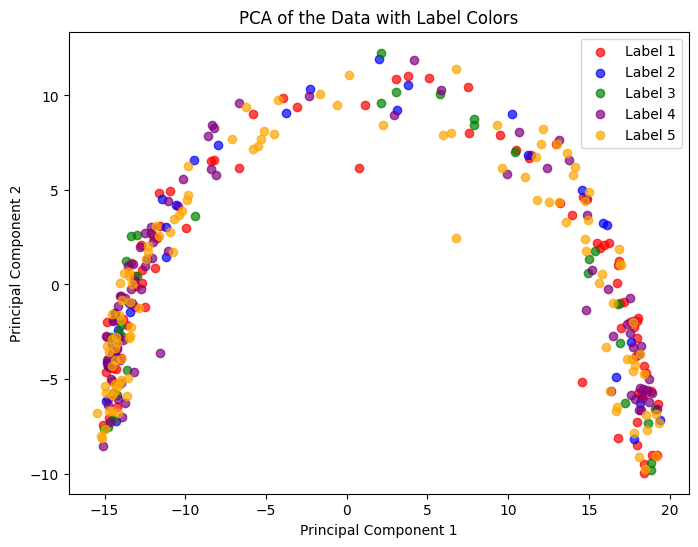

In [55]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(clf_output)

labels = df_train['condition_label'][:350]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the Data with Label Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Bio_ClinicalBERT

https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT

https://arxiv.org/pdf/1904.03323.pdf

In [56]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [7]:
abstract_example = df_train.medical_abstract[0]

In [64]:
tokenized_example = tokenizer.encode(abstract_example, add_special_tokens=True)

In [65]:
len(tokenized_example)

415

In [8]:
def truncate_to_n_words(input_string, n):
    words = input_string.split()[:n]
    truncated_string = ' '.join(words)
    return truncated_string

In [75]:
tokenized = df_train.medical_abstract.apply((lambda x: tokenizer.encode(truncate_to_n_words(x, 200), add_special_tokens=True)))

In [76]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [77]:
max_len

498

In [78]:
np.array(padded).shape

(11550, 498)

In [79]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(11550, 498)

In [10]:
import torch

In [81]:
def embed_with_BERT(padded, attention_mask):

  input_ids = torch.tensor(padded)
  attention_mask_tensor = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask_tensor)

  return last_hidden_states[0][:,0,:].numpy()

In [82]:
i=0
step=50
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])

In [84]:
features_temp.shape

(50, 768)

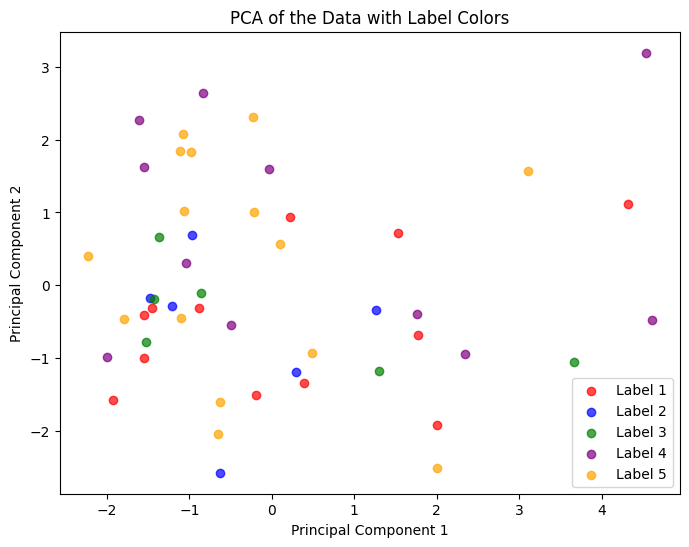

In [85]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_temp)

labels = df_train['condition_label'][:50]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the Data with Label Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
i=0
step=350
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])

# ClinicalBERT

In [1]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [17]:
tokenized = df_train.medical_abstract.apply((lambda x: tokenizer.encode(truncate_to_n_words(x, 200), add_special_tokens=True)))

In [18]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [19]:
max_len

493

In [20]:
np.array(padded).shape

(11550, 493)

In [21]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(11550, 493)

In [22]:
def embed_with_BERT(padded, attention_mask):

  input_ids = torch.tensor(padded)
  attention_mask_tensor = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask_tensor)

  return last_hidden_states[0][:,0,:].numpy()

In [23]:
i=0
step=50
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])

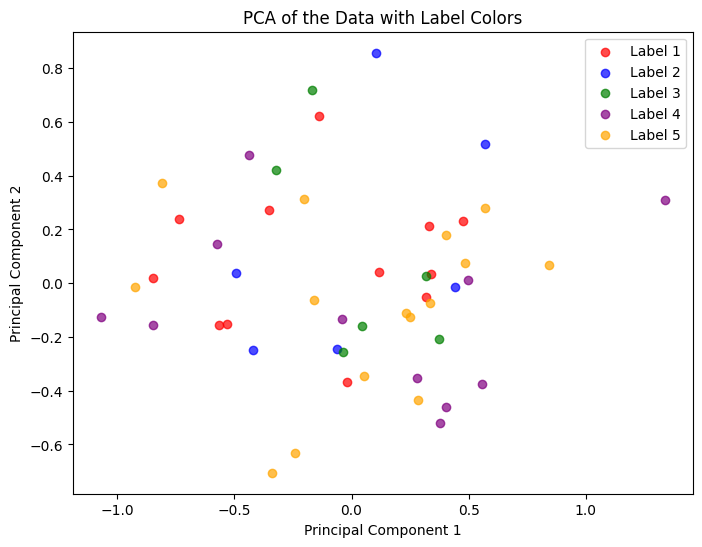

In [25]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_temp)

labels = df_train['condition_label'][:50]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the Data with Label Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
i=0
step=350
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])